In [51]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import os
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
BASE_PATH = '/content/drive/Shared drives/Citadel Datathon 2020 Summer/datasets'
UK_INFLATION_CSV = 'UK_inflation.csv'
UK_HOUSE_PRICE_CSV = 'UK_house_price.csv'
UK_HOUSE_SALES_VOLUME_CSV = 'UK_house_sales_volume.csv'

# 1.Read Data

In [4]:
london_inflation = pd.read_csv(os.path.join(BASE_PATH, UK_INFLATION_CSV))

In [5]:
price = pd.read_csv(os.path.join(BASE_PATH, UK_HOUSE_PRICE_CSV))
vol = pd.read_csv(os.path.join(BASE_PATH, UK_HOUSE_SALES_VOLUME_CSV))

In [6]:
price.index = pd.to_datetime(price['Unnamed: 0'])
price = price.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 34',  'Unnamed: 37',  'Unnamed: 47'])

In [7]:
price.head()

,City of London,Barking & Dagenham,Barnet,Bexley,Brent,Bromley,Camden,Croydon,Ealing,Enfield,Greenwich,Hackney,Hammersmith & Fulham,Haringey,Harrow,Havering,Hillingdon,Hounslow,Islington,Kensington & Chelsea,Kingston upon Thames,Lambeth,Lewisham,Merton,Newham,Redbridge,Richmond upon Thames,Southwark,Sutton,Tower Hamlets,Waltham Forest,Wandsworth,Westminster,Inner London,Outer London,NORTH EAST,NORTH WEST,YORKS & THE HUMBER,EAST MIDLANDS,WEST MIDLANDS,EAST OF ENGLAND,LONDON,SOUTH EAST,SOUTH WEST,England
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1995-01-01,91448.98487,50460.22660,93284.51832,64958.09036,71306.56698,81671.47692,120932.8881,69158.16225,79885.89069,72514.69096,62300.10169,61296.52637,124902.8602,76287.56947,84769.52599,68000.13774,73834.82964,72231.70537,92516.48557,182694.8326,80875.84843,67770.98843,60491.26109,82070.61330,53539.31919,72189.58437,109326.1245,67885.20344,71536.97357,59865.18995,61319.44913,88559.04381,133025.2772,78251.97650,72958.79836,42076.35411,43958.48001,44803.42878,45544.52227,48527.52339,56701.59610,74435.76052,64018.87894,54705.15790,53202.77128
1995-02-01,82202.77314,51085.77983,93190.16963,64787.92069,72022.26197,81657.55944,119508.8622,68951.09542,80897.06551,73155.19746,60993.26863,63187.08332,122087.7180,78901.21036,83396.10525,69393.51294,75031.06960,71051.55852,94342.37334,182345.2463,81230.13524,65381.51908,60869.27091,79982.74872,53153.88306,72141.62610,111103.0394,64799.06480,70893.20851,62318.53353,60252.12246,88641.01678,131468.3096,75885.70201,72937.88262,42571.98949,43925.42289,44528.80721,46051.57066,49341.29029,56593.59475,72777.93709,63715.02399,54356.14843,53096.15490
1995-03-01,79120.70256,51268.96956,92247.52435,64367.49344,72015.76274,81449.31143,120282.2131,68712.44341,81379.86288,72190.44144,61377.83464,63593.29935,120635.9467,78521.94855,83416.23759,69368.02407,74188.66949,72097.99411,93465.86407,182878.8231,81111.48848,66336.51868,60288.03002,80661.68279,53458.26393,72501.35502,107325.4742,65763.29719,70306.83844,63938.67686,60871.08493,87124.81523,132260.3417,76591.59947,72714.53478,42369.72984,44434.86810,45200.46775,45383.82395,49442.17973,56171.18278,73896.84204,64113.60858,53583.07667,53201.28430
1995-04-01,77101.20804,53133.50526,90762.87492,64277.66881,72965.63094,81124.41227,120097.8990,68610.04641,82188.90498,71442.92235,61927.72460,65139.64403,121424.6241,79545.57477,83567.88439,69444.26215,73911.40591,71890.28339,93344.49305,184176.9168,81672.80476,66388.77160,59471.03136,79990.54333,54479.75395,72228.60295,106875.0000,63073.62117,69411.94390,66233.19383,60971.39722,87026.00225,133370.2036,76851.56697,72591.92469,42095.84360,44267.77960,45614.34341,46124.23045,49455.93299,56567.89582,74455.28754,64623.22395,54786.01938,53590.85480
1995-05-01,84409.14932,53042.24852,90258.00033,63997.13588,73704.04743,81542.61561,119929.2782,68844.91690,82077.05525,70630.77955,63512.99103,66193.99212,124433.5390,79374.03490,83853.65615,68534.52248,73117.12416,72877.47219,94346.39917,191474.1141,82123.51084,69035.11076,58551.38387,80873.98643,55803.95958,72366.64122,107707.6799,64420.49933,69759.21989,66432.85846,61494.16938,86518.05945,133911.1117,79129.19443,72752.99414,43266.45165,44223.61973,44830.98563,45878.00396,50369.66188,56479.80183,75432.02786,64530.36358,54698.83831,53678.24041


In [8]:
vol.index = pd.to_datetime(vol['Unnamed: 0.1'])
vol = vol.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 34',  'Unnamed: 37',  'Unnamed: 47'])
vol = vol.iloc[1:, :]
vol = vol.astype(int)

In [9]:
price.columns

Index(['City of London', 'Barking & Dagenham', 'Barnet', 'Bexley', 'Brent',
       'Bromley', 'Camden', 'Croydon', 'Ealing', 'Enfield', 'Greenwich',
       'Hackney', 'Hammersmith & Fulham', 'Haringey', 'Harrow', 'Havering',
       'Hillingdon', 'Hounslow', 'Islington', 'Kensington & Chelsea',
       'Kingston upon Thames', 'Lambeth', 'Lewisham', 'Merton', 'Newham',
       'Redbridge', 'Richmond upon Thames', 'Southwark', 'Sutton',
       'Tower Hamlets', 'Waltham Forest', 'Wandsworth', 'Westminster',
       'Inner London', 'Outer London', 'NORTH EAST', 'NORTH WEST',
       'YORKS & THE HUMBER', 'EAST MIDLANDS', 'WEST MIDLANDS',
       'EAST OF ENGLAND', 'LONDON', 'SOUTH EAST', 'SOUTH WEST', 'England'],
      dtype='object')

# 2.Preprocessing

In [10]:
# set host and London boroughs
host_boroughs = ['Barking & Dagenham', 'Greenwich', 'Hackney', 'Newham', 'Tower Hamlets', 'Waltham Forest']
london_boroughs = price.columns[:33]
other_place_with_venue = ['EAST OF ENGLAND', 'SOUTH EAST', 'LONDON']
england_big_region = ['NORTH EAST', 'NORTH WEST', 'YORKS & THE HUMBER', 'EAST MIDLANDS', 'WEST MIDLANDS',
                      'EAST OF ENGLAND', 'LONDON', 'SOUTH EAST', 'SOUTH WEST']

In [11]:
crisis_multiplier = pd.DataFrame(price.loc["2008-06-01",] / price.loc["2009-04-01",])
crisis_multiplier = crisis_multiplier.reset_index()
crisis_multiplier.columns=['area', 'crisis_multiplier']
crisis_multiplier.head()

,area,crisis_multiplier
0,City of London,1.218124
1,Barking & Dagenham,1.253056
2,Barnet,1.189196
3,Bexley,1.170539
4,Brent,1.102469


In [12]:
# change price shape
price_unstack = pd.DataFrame(price.unstack()).reset_index()
price_unstack.columns = ['area', 'date', 'price']
price_unstack = price_unstack[(price_unstack['date']<pd.to_datetime("2008-07-01")) | (price_unstack['date']>pd.to_datetime("2009-03-01"))]

# crisis adjustment
price_unstack = price_unstack.merge(crisis_multiplier, on="area", how="left")
price_unstack.loc[price_unstack['date']<pd.to_datetime("2008-07-01"), 'crisis_multiplier'] = 1
price_unstack = price_unstack[price_unstack['area'].isin(london_boroughs)]
price_unstack = price_unstack.reset_index()
price_unstack

,index,area,date,price,crisis_multiplier
0,0,City of London,1995-01-01,9.144898e+04,1.000000
1,1,City of London,1995-02-01,8.220277e+04,1.000000
2,2,City of London,1995-03-01,7.912070e+04,1.000000
3,3,City of London,1995-04-01,7.710121e+04,1.000000
4,4,City of London,1995-05-01,8.440915e+04,1.000000
...,...,...,...,...,...
9697,9697,Westminster,2019-11-01,9.552646e+05,1.057497
9698,9698,Westminster,2019-12-01,9.609431e+05,1.057497
9699,9699,Westminster,2020-01-01,1.001284e+06,1.057497
9700,9700,Westminster,2020-02-01,1.042884e+06,1.057497


## England Regions!

In [13]:
# change price shape
price_unstack_england = pd.DataFrame(price.unstack()).reset_index()
price_unstack_england.columns = ['area', 'date', 'price']
price_unstack_england = price_unstack_england[(price_unstack_england['date']<pd.to_datetime("2008-07-01")) | (price_unstack_england['date']>pd.to_datetime("2009-03-01"))]

# crisis adjustment
price_unstack_england = price_unstack_england.merge(crisis_multiplier, on="area", how="left")
price_unstack_england.loc[price_unstack_england['date']<pd.to_datetime("2008-07-01"), 'crisis_multiplier'] = 1
price_unstack_england = price_unstack_england[price_unstack_england['area'].isin(england_big_region)]
price_unstack_england = price_unstack_england.reset_index()
price_unstack_england

,index,area,date,price,crisis_multiplier
0,10290,NORTH EAST,1995-01-01,42076.35411,1.000000
1,10291,NORTH EAST,1995-02-01,42571.98949,1.000000
2,10292,NORTH EAST,1995-03-01,42369.72984,1.000000
3,10293,NORTH EAST,1995-04-01,42095.84360,1.000000
4,10294,NORTH EAST,1995-05-01,43266.45165,1.000000
...,...,...,...,...,...
2641,12931,SOUTH WEST,2019-11-01,256874.86350,1.164642
2642,12932,SOUTH WEST,2019-12-01,256576.84810,1.164642
2643,12933,SOUTH WEST,2020-01-01,258185.02720,1.164642
2644,12934,SOUTH WEST,2020-02-01,258128.73570,1.164642


In [14]:
def before_after(x):
    """determine if before or after announce"""
    if x < pd.to_datetime('2005-07-06'):
        return 0
    return 1
def before_after_construct(x):
    """determine if before or after announce"""
    if x < pd.to_datetime('2007-07-01'):
        return 0
    return 1

#### Dataset inside London

In [15]:
# add dummy variables
price_unstack['before_after'] = price_unstack['date'].apply(before_after_construct)
price_unstack['if_host'] = price_unstack['area'].isin(host_boroughs) * 1
price_unstack['if_host x before_after'] = price_unstack['if_host'] * price_unstack['before_after']

In [16]:
# multiply by inflation
price_unstack['year'] = price_unstack['date'].dt.year
price_unstack = price_unstack.merge(london_inflation[['year', 'multiplier']], on='year', how='left')
price_unstack.dropna(inplace=True)
price_unstack['price_inflated'] = price_unstack['price'] * price_unstack['multiplier']

In [17]:
# crisis multiplier
price_unstack['price_inflated'] = price_unstack['price']*price_unstack['crisis_multiplier']
price_unstack

,index,area,date,price,crisis_multiplier,before_after,if_host,if_host x before_after,year,multiplier,price_inflated
0,0,City of London,1995-01-01,9.144898e+04,1.000000,0,0,0,1995,1.89,9.144898e+04
1,1,City of London,1995-02-01,8.220277e+04,1.000000,0,0,0,1995,1.89,8.220277e+04
2,2,City of London,1995-03-01,7.912070e+04,1.000000,0,0,0,1995,1.89,7.912070e+04
3,3,City of London,1995-04-01,7.710121e+04,1.000000,0,0,0,1995,1.89,7.710121e+04
4,4,City of London,1995-05-01,8.440915e+04,1.000000,0,0,0,1995,1.89,8.440915e+04
...,...,...,...,...,...,...,...,...,...,...,...
9682,9682,Westminster,2018-08-01,9.823558e+05,1.057497,1,0,0,2018,1.00,1.038839e+06
9683,9683,Westminster,2018-09-01,1.023157e+06,1.057497,1,0,0,2018,1.00,1.081986e+06
9684,9684,Westminster,2018-10-01,1.025837e+06,1.057497,1,0,0,2018,1.00,1.084819e+06
9685,9685,Westminster,2018-11-01,1.030332e+06,1.057497,1,0,0,2018,1.00,1.089573e+06


In [18]:
# # add time period stamps
# price_unstack['<2005'] = (price_unstack['year'] < 2005) * 1
# price_unstack['2005-2012'] = price_unstack['year'].isin(range(2005, 2012)) * 1
# price_unstack['>2012'] = (price_unstack['year'] > 2012) * 1
# # add more interactions
# price_unstack['<2005 x if_host'] = price_unstack['<2005'] * price_unstack['if_host']
# price_unstack['2005-2012 x if_host'] = price_unstack['2005-2012'] * price_unstack['if_host']
# price_unstack['>2012 x if_host'] = price_unstack['>2012'] * price_unstack['if_host']

#### Dataset for Bigger Regions

In [19]:
# Dummy Variable
price_unstack_england['before_after'] = price_unstack_england['date'].apply(before_after_construct)
price_unstack_england['if_host'] = price_unstack_england['area'].isin(other_place_with_venue) * 1
price_unstack_england['if_host x before_after'] = price_unstack_england['if_host'] * price_unstack_england['before_after']

In [20]:
price_unstack_england

,index,area,date,price,crisis_multiplier,before_after,if_host,if_host x before_after
0,10290,NORTH EAST,1995-01-01,42076.35411,1.000000,0,0,0
1,10291,NORTH EAST,1995-02-01,42571.98949,1.000000,0,0,0
2,10292,NORTH EAST,1995-03-01,42369.72984,1.000000,0,0,0
3,10293,NORTH EAST,1995-04-01,42095.84360,1.000000,0,0,0
4,10294,NORTH EAST,1995-05-01,43266.45165,1.000000,0,0,0
...,...,...,...,...,...,...,...,...
2641,12931,SOUTH WEST,2019-11-01,256874.86350,1.164642,1,0,0
2642,12932,SOUTH WEST,2019-12-01,256576.84810,1.164642,1,0,0
2643,12933,SOUTH WEST,2020-01-01,258185.02720,1.164642,1,0,0
2644,12934,SOUTH WEST,2020-02-01,258128.73570,1.164642,1,0,0


In [21]:
# multiply by inflation
price_unstack_england['year'] = price_unstack_england['date'].dt.year
price_unstack_england = price_unstack_england.merge(london_inflation[['year', 'multiplier']], on='year', how='left')
price_unstack_england.dropna(inplace=True)
price_unstack_england['price_inflated'] = price_unstack_england['price'] *price_unstack_england['multiplier']

# crisis multiplier
price_unstack_england['price_inflated'] = price_unstack_england['price']*price_unstack_england['crisis_multiplier']
price_unstack_england

,index,area,date,price,crisis_multiplier,before_after,if_host,if_host x before_after,year,multiplier,price_inflated
0,10290,NORTH EAST,1995-01-01,42076.35411,1.000000,0,0,0,1995,1.89,42076.354110
1,10291,NORTH EAST,1995-02-01,42571.98949,1.000000,0,0,0,1995,1.89,42571.989490
2,10292,NORTH EAST,1995-03-01,42369.72984,1.000000,0,0,0,1995,1.89,42369.729840
3,10293,NORTH EAST,1995-04-01,42095.84360,1.000000,0,0,0,1995,1.89,42095.843600
4,10294,NORTH EAST,1995-05-01,43266.45165,1.000000,0,0,0,1995,1.89,43266.451650
...,...,...,...,...,...,...,...,...,...,...,...
2626,12916,SOUTH WEST,2018-08-01,258465.43180,1.164642,1,0,0,2018,1.00,301019.774097
2627,12917,SOUTH WEST,2018-09-01,258838.52872,1.164642,1,0,0,2018,1.00,301454.298551
2628,12918,SOUTH WEST,2018-10-01,256883.00987,1.164642,1,0,0,2018,1.00,299176.818586
2629,12919,SOUTH WEST,2018-11-01,256804.10465,1.164642,1,0,0,2018,1.00,299084.922229


In [22]:
price_unstack_england.tail()

,index,area,date,price,crisis_multiplier,before_after,if_host,if_host x before_after,year,multiplier,price_inflated
2626,12916,SOUTH WEST,2018-08-01,258465.43180,1.164642,1,0,0,2018,1.0,301019.774097
2627,12917,SOUTH WEST,2018-09-01,258838.52872,1.164642,1,0,0,2018,1.0,301454.298551
2628,12918,SOUTH WEST,2018-10-01,256883.00987,1.164642,1,0,0,2018,1.0,299176.818586
2629,12919,SOUTH WEST,2018-11-01,256804.10465,1.164642,1,0,0,2018,1.0,299084.922229
2630,12920,SOUTH WEST,2018-12-01,256811.90106,1.164642,1,0,0,2018,1.0,299094.002258


# 3.BoxCox

In [23]:
def boxcox(a):
  # convert to gaussian dist
  y, lam = stats.boxcox(a)
  # y = np.log(y)
  # check with qq plot
  fig, ax = plt.subplots(figsize=(20, 10))
  prob = stats.probplot(y, dist=stats.norm, plot=ax)
  plt.show()
  return y, lam

# 4.Hedonic Model

## 4.1Logged Price

4.1.1: London Borough

In [24]:
# equal years
price_unstack = price_unstack[(price_unstack['date']>=pd.to_datetime("2001-01-01")) & (price_unstack['date']<=pd.to_datetime("2014-09-01"))]
price_unstack = price_unstack.reset_index()
price_unstack

,level_0,index,area,date,price,crisis_multiplier,before_after,if_host,if_host x before_after,year,multiplier,price_inflated
0,72,72,City of London,2001-01-01,284262.1358,1.000000,0,0,0,2001,1.60,2.842621e+05
1,73,73,City of London,2001-02-01,198137.0177,1.000000,0,0,0,2001,1.60,1.981370e+05
2,74,74,City of London,2001-03-01,189033.0279,1.000000,0,0,0,2001,1.60,1.890330e+05
3,75,75,City of London,2001-04-01,205494.0961,1.000000,0,0,0,2001,1.60,2.054941e+05
4,76,76,City of London,2001-05-01,223458.8283,1.000000,0,0,0,2001,1.60,2.234588e+05
...,...,...,...,...,...,...,...,...,...,...,...,...
5143,9631,9631,Westminster,2014-05-01,896171.4371,1.057497,1,0,0,2014,1.09,9.476988e+05
5144,9632,9632,Westminster,2014-06-01,923345.4157,1.057497,1,0,0,2014,1.09,9.764353e+05
5145,9633,9633,Westminster,2014-07-01,941640.9299,1.057497,1,0,0,2014,1.09,9.957827e+05
5146,9634,9634,Westminster,2014-08-01,949689.7261,1.057497,1,0,0,2014,1.09,1.004294e+06


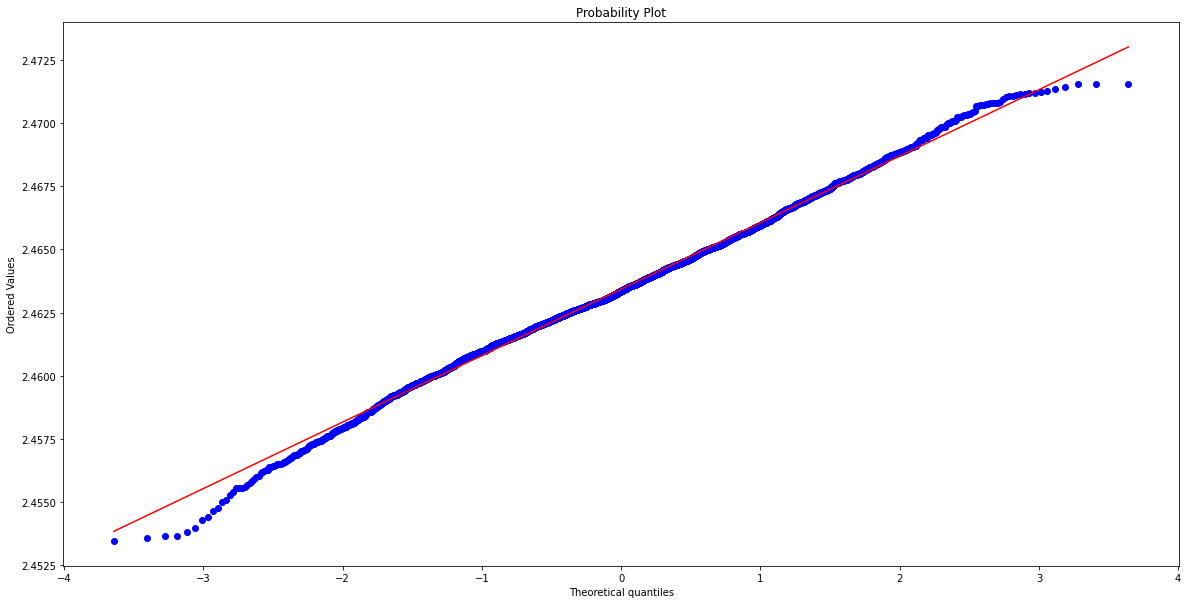

In [25]:
price_unstack['y'], lamb = boxcox(price_unstack['price_inflated'])

In [26]:
y = price_unstack['y']
X = price_unstack[['before_after', 'if_host', 'if_host x before_after']].values
X = np.hstack((X, np.ones((X.shape[0], 1))))    # add constant
# fit and print summary
res = sm.OLS(y, X).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     1328.
Date:                Sun, 19 Jul 2020   Prob (F-statistic):               0.00
Time:                        15:07:08   Log-Likelihood:                 24740.
No. Observations:                5148   AIC:                        -4.947e+04
Df Residuals:                    5144   BIC:                        -4.944e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0031    6.1e-05     50.858      0.0

In [27]:
def reverse(res_c, bc_lambda_c):
    print((res_c.params[-1] * bc_lambda_c + 1) ** (1 / bc_lambda_c))
    return ((res_c.params+res_c.params[-1]) * bc_lambda_c + 1) ** (1 / bc_lambda_c) - ((res_c.params[-1]) * bc_lambda_c + 1) ** (1 / bc_lambda_c)

In [28]:
reverse(res, lamb)

231262.74002217612


x1       149878.966073
x2       -56959.037126
x3         9873.193318
const              NaN
dtype: float64

In [29]:
# X = price_unstack[['before_after', 'if_host', 'if_host x before_after']].values
# X = np.hstack((X, np.ones((X.shape[0], 1))))    # add constant
# # fit and print summary
# res = sm.OLS(price_unstack['price_inflated'].diff()[1:].values, X[1:, ]).fit()
# print(res.summary())

4.1.2: England Regions

In [30]:
# equal years
price_unstack_england = price_unstack_england[(price_unstack_england['date']>=pd.to_datetime("2001-01-01")) & (price_unstack_england['date']<=pd.to_datetime("2014-09-01"))]
price_unstack_england = price_unstack_england.reset_index()
price_unstack_england

,level_0,index,area,date,price,crisis_multiplier,before_after,if_host,if_host x before_after,year,multiplier,price_inflated
0,72,10362,NORTH EAST,2001-01-01,49836.75810,1.000000,0,0,0,2001,1.60,49836.758100
1,73,10363,NORTH EAST,2001-02-01,49044.57205,1.000000,0,0,0,2001,1.60,49044.572050
2,74,10364,NORTH EAST,2001-03-01,49587.12367,1.000000,0,0,0,2001,1.60,49587.123670
3,75,10365,NORTH EAST,2001-04-01,51735.07746,1.000000,0,0,0,2001,1.60,51735.077460
4,76,10366,NORTH EAST,2001-05-01,52411.82582,1.000000,0,0,0,2001,1.60,52411.825820
...,...,...,...,...,...,...,...,...,...,...,...,...
1399,2575,12865,SOUTH WEST,2014-05-01,204097.52200,1.164642,1,0,0,2014,1.09,237700.606763
1400,2576,12866,SOUTH WEST,2014-06-01,204781.39090,1.164642,1,0,0,2014,1.09,238497.069409
1401,2577,12867,SOUTH WEST,2014-07-01,209034.42640,1.164642,1,0,0,2014,1.09,243450.334442
1402,2578,12868,SOUTH WEST,2014-08-01,211731.13780,1.164642,1,0,0,2014,1.09,246591.038600


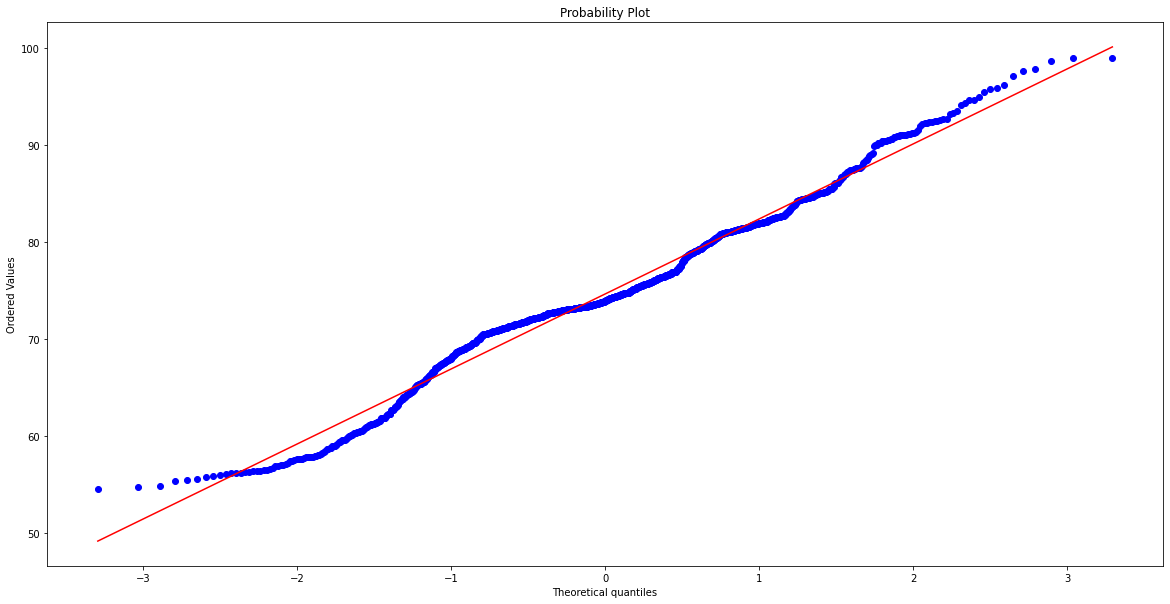

In [31]:
price_unstack_england['y'], lamb = boxcox(price_unstack_england['price_inflated'])

In [32]:
price_unstack_england

,level_0,index,area,date,price,crisis_multiplier,before_after,if_host,if_host x before_after,year,multiplier,price_inflated,y
0,72,10362,NORTH EAST,2001-01-01,49836.75810,1.000000,0,0,0,2001,1.60,49836.758100,54.810058
1,73,10363,NORTH EAST,2001-02-01,49044.57205,1.000000,0,0,0,2001,1.60,49044.572050,54.576938
2,74,10364,NORTH EAST,2001-03-01,49587.12367,1.000000,0,0,0,2001,1.60,49587.123670,54.736900
3,75,10365,NORTH EAST,2001-04-01,51735.07746,1.000000,0,0,0,2001,1.60,51735.077460,55.357550
4,76,10366,NORTH EAST,2001-05-01,52411.82582,1.000000,0,0,0,2001,1.60,52411.825820,55.549075
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1399,2575,12865,SOUTH WEST,2014-05-01,204097.52200,1.164642,1,0,0,2014,1.09,237700.606763,82.619085
1400,2576,12866,SOUTH WEST,2014-06-01,204781.39090,1.164642,1,0,0,2014,1.09,238497.069409,82.690922
1401,2577,12867,SOUTH WEST,2014-07-01,209034.42640,1.164642,1,0,0,2014,1.09,243450.334442,83.133680
1402,2578,12868,SOUTH WEST,2014-08-01,211731.13780,1.164642,1,0,0,2014,1.09,246591.038600,83.410919


In [33]:
y = price_unstack_england['y']
X = price_unstack_england[['before_after', 'if_host', 'if_host x before_after']].values
X = np.hstack((X, np.ones((X.shape[0], 1))))    # add constant
# fit and print summary
res = sm.OLS(y, X).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.626
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     781.2
Date:                Sun, 19 Jul 2020   Prob (F-statistic):          2.33e-298
Time:                        15:07:09   Log-Likelihood:                -4183.4
No. Observations:                1404   AIC:                             8375.
Df Residuals:                    1400   BIC:                             8396.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             7.2368      0.312     23.213      0.0

In [34]:
reverse(res, lamb)

110707.79614877512


x1       5.249515e+04
x2       7.001781e+04
x3       1.076598e+04
const    1.508555e+06
dtype: float64

## 4.2Pct Change

4.2.1 London Borough

In [35]:
price_unstack

,level_0,index,area,date,price,crisis_multiplier,before_after,if_host,if_host x before_after,year,multiplier,price_inflated,y
0,72,72,City of London,2001-01-01,284262.1358,1.000000,0,0,0,2001,1.60,2.842621e+05,2.463584
1,73,73,City of London,2001-02-01,198137.0177,1.000000,0,0,0,2001,1.60,1.981370e+05,2.461131
2,74,74,City of London,2001-03-01,189033.0279,1.000000,0,0,0,2001,1.60,1.890330e+05,2.460784
3,75,75,City of London,2001-04-01,205494.0961,1.000000,0,0,0,2001,1.60,2.054941e+05,2.461395
4,76,76,City of London,2001-05-01,223458.8283,1.000000,0,0,0,2001,1.60,2.234588e+05,2.461988
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5143,9631,9631,Westminster,2014-05-01,896171.4371,1.057497,1,0,0,2014,1.09,9.476988e+05,2.469605
5144,9632,9632,Westminster,2014-06-01,923345.4157,1.057497,1,0,0,2014,1.09,9.764353e+05,2.469721
5145,9633,9633,Westminster,2014-07-01,941640.9299,1.057497,1,0,0,2014,1.09,9.957827e+05,2.469796
5146,9634,9634,Westminster,2014-08-01,949689.7261,1.057497,1,0,0,2014,1.09,1.004294e+06,2.469828


In [36]:
# X = price_unstack[['before_after', 'if_host', 'if_host x before_after']].values
# X = np.hstack((X, np.ones((X.shape[0], 1))))    # add constant
# # fit and print summary
# res = sm.OLS(price_unstack['price_inflated'].pct_change()[1:].values, X[1:, ]).fit()
# print(res.summary())

In [37]:
price_unstack.groupby(['if_host']).mean()[['price_inflated']]

,price_inflated
if_host,
0,336518.563296
1,238385.853602


4.2.2 England Regions

In [38]:
def region(x):
    if x in other_place_with_venue:
      return "Olympic Regions"
    else:
      return "Other Regions"
price_unstack_england['region'] = price_unstack_england['area'].apply(region)

In [39]:
price_unstack_ey1 = pd.DataFrame(price_unstack_england.groupby(['date', 'region']).mean()['price_inflated'])
price_unstack_ey1 = price_unstack_ey1.reset_index()

In [40]:
import plotly.express as px
fig = px.line(price_unstack_ey1, x='date', y='price_inflated', color="region", template="xgridoff",  width=1000, height=600)

fig.update_layout(title="England Real Estate Price Trend by Olympic Zones", xaxis_title="DATE", yaxis_title="Price Inflation Adjusted")

fig.show()

In [ ]:
import seaborn as sns
sns.set()
sns.set_context("talk")
plt.figure(figsize=(16, 8))
palette = sns.color_palette("mako_r", 2)
ax = sns.lineplot(x='date', y='price_inflated', style="region",
                  hue="region", palette=palette, data=price_unstack_england, legend="brief")
ax.axvline(pd.to_datetime("2007-07-01"), color='orange', linestyle="dashed")
ax.legend(loc='upper left')
ax.set(xlabel='Date', ylabel='Adjusted Mean Price as for 2018: Pounds')
ax.set_title('London Real Estate Price Trend by Zones')
plt.show()

In [41]:
X = price_unstack_england[['before_after', 'if_host', 'if_host x before_after']].values
X = np.hstack((X, np.ones((X.shape[0], 1))))    # add constant
# fit and print summary
res = sm.OLS(price_unstack_england['price_inflated'].pct_change()[1:].values, X[1:, ]).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.6676
Date:                Sun, 19 Jul 2020   Prob (F-statistic):              0.572
Time:                        15:07:11   Log-Likelihood:                 2267.3
No. Observations:                1403   AIC:                            -4527.
Df Residuals:                    1399   BIC:                            -4506.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0040      0.003     -1.260      0.2

## 4.3With Time Stamp

In [42]:
X = price_unstack[['<2005', '2005-2012', '>2012', 'if_host', '<2005 x if_host', '2005-2012 x if_host', '>2012 x if_host']].values
X = np.hstack((X, np.ones((X.shape[0], 1))))    # add constant
# fit and print summary
res = sm.OLS(y, X).fit()
print(res.summary())

KeyError: ignored